In [ ]:
!pip install tf_agents

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tempfile
import gin
import tensorflow_probability as tfp
from tf_agents.agents import data_converter
from tf_agents.agents import tf_agent
from tf_agents.distributions import utils as distribution_utils
from tf_agents.networks import network
from tf_agents.policies import actor_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import greedy_policy
from tf_agents.policies import q_policy
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.typing import types
from tf_agents.utils import common
import typing_extensions
import tensorflow as tf
from tf_agents.networks import actor_distribution_network
from tf_agents.environments import suite_gym
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.utils import common
import collections
from typing import Optional, Callable , Text
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.environments import tf_py_environment
import tf_agents
from tf_agents.metrics import tf_metrics
from tf_agents.trajectories import trajectory
from tf_agents.policies import random_tf_policy
from tf_agents.environments.tf_py_environment import TFPyEnvironment
import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.networks.q_network import QNetwork
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils.common import function

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
Literal = typing_extensions.Literal


class BehavioralCloningLossInfo(collections.namedtuple(
    'BehavioralCloningLossInfo', ('loss'))):
  pass


@gin.configurable
class BehavioralCloningAgent(tf_agent.TFAgent):
  

  def __init__(
      self,
      time_step_spec: ts.TimeStep,
      action_spec: types.NestedTensorSpec,
      cloning_network: network.Network,
      optimizer: types.Optimizer,
      num_outer_dims: Literal[1, 2] = 2,  # pylint: disable=bad-whitespace
      epsilon_greedy: types.Float = 0.1,
      loss_fn: Optional[Callable[[types.NestedTensor, bool],
                                 types.Tensor]] = None,
      gradient_clipping: Optional[types.Float] = None,
      # Params for debugging.
      debug_summaries: bool = False,
      summarize_grads_and_vars: bool = False,
      train_step_counter: Optional[tf.Variable] = None,
      name: Optional[Text] = None):
    
    tf.Module.__init__(self, name=name)
    self._cloning_network = cloning_network
    self._optimizer = optimizer
    self._gradient_clipping = gradient_clipping

    action_spec = tensor_spec.from_spec(action_spec)
    flat_action_spec = tf.nest.flatten(action_spec)
    continuous_specs = [tensor_spec.is_continuous(s) for s in flat_action_spec]

    if not flat_action_spec:
      raise ValueError('The `action_spec` must contain at least one action.')

    single_discrete_scalar_action = (
        len(flat_action_spec) == 1 and
        flat_action_spec[0].shape.rank == 0 and
        not tensor_spec.is_continuous(flat_action_spec[0]))
    single_continuous_action = (
        len(flat_action_spec) == 1 and
        tensor_spec.is_continuous(flat_action_spec[0]))

    if (not loss_fn and not single_discrete_scalar_action and
        not single_continuous_action):
      raise ValueError(
          'A `loss_fn` must be provided unless there is a single, scalar '
          'discrete action or a single (scalar or non-scalar) continuous '
          'action.')

    self._network_output_spec = cloning_network.create_variables(
        time_step_spec.observation)

    # If there is a mix of continuous and discrete actions we want to use an
    # actor policy so we can use the `setup_as_continuous` method as long as the
    # user provided a custom loss_fn which we verified above.
    if any(continuous_specs):
      policy, collect_policy = self._setup_as_continuous(
          time_step_spec, action_spec, loss_fn)
    else:
      policy, collect_policy = self._setup_as_discrete(time_step_spec,
                                                       action_spec, loss_fn,
                                                       epsilon_greedy)

    super(BehavioralCloningAgent, self).__init__(
        time_step_spec,
        action_spec,
        policy,
        collect_policy,
        train_sequence_length=None,
        debug_summaries=debug_summaries,
        summarize_grads_and_vars=summarize_grads_and_vars,
        train_step_counter=train_step_counter)

    self._as_trajectory = data_converter.AsTrajectory(
        self.data_context, sequence_length=None,
        num_outer_dims=num_outer_dims)

  @property
  def cloning_network(self):
    return self._cloning_network

  def _discrete_loss(self, experience, training=False):
    batch_size = (
        tf.compat.dimension_value(experience.step_type.shape[0]) or
        tf.shape(experience.step_type)[0])

    network_state = self._cloning_network.get_initial_state(batch_size)
    action, _ = self._cloning_network(
        experience.observation,
        step_type=experience.step_type,
        training=training,
        network_state=network_state)

    # Get logits if the output of the cloning network is a distribution.
    if isinstance(action, tfp.distributions.Distribution):
      bc_logits = action.logits_parameter()
    else:
      bc_logits = action

    def loss(action, bc_logits, spec):
      # Subtract the minimum so that we get a proper cross entropy loss on
      # [0, maximum - minimum).
      return tf.nn.sparse_softmax_cross_entropy_with_logits(
          labels=action - spec.minimum, logits=bc_logits)

    losses = tf.nest.map_structure(loss, experience.action, bc_logits,
                                   self.action_spec)
    losses = tf.nest.flatten(losses)
    return tf.add_n(losses)

  def _continuous_loss_fn(self, experience, training: bool = False):
    batch_size = (
        tf.compat.dimension_value(experience.step_type.shape[0]) or
        tf.shape(experience.step_type)[0])
    network_state = self._cloning_network.get_initial_state(batch_size)
    bc_output, _ = self._cloning_network(
        experience.observation,
        step_type=experience.step_type,
        training=training,
        network_state=network_state)

    if isinstance(bc_output, tfp.distributions.Distribution):
      bc_action = bc_output.sample()
    else:
      bc_action = bc_output

    losses = tf.nest.map_structure(tf.losses.mse, experience.action, bc_action)
    losses = tf.nest.flatten(losses)
    return tf.add_n(losses)

  def _setup_as_discrete(self, time_step_spec, action_spec, loss_fn,
                         epsilon_greedy):
    self._bc_loss_fn = loss_fn or self._discrete_loss

    if any(isinstance(d, distribution_utils.DistributionSpecV2) for
           d in tf.nest.flatten([self._network_output_spec])):
      # If the output of the cloning network contains a distribution.
      base_policy = actor_policy.ActorPolicy(time_step_spec, action_spec,
                                             self._cloning_network)
    else:
      # If the output of the cloning network is logits.
      base_policy = q_policy.QPolicy(
          time_step_spec,
          action_spec,
          q_network=self._cloning_network,
          validate_action_spec_and_network=False)
    policy = greedy_policy.GreedyPolicy(base_policy)
    collect_policy = epsilon_greedy_policy.EpsilonGreedyPolicy(
        base_policy, epsilon=epsilon_greedy)
    return policy, collect_policy

  def _setup_as_continuous(self, time_step_spec, action_spec, loss_fn):
    self._bc_loss_fn = loss_fn or self._continuous_loss_fn
    collect_policy = actor_policy.ActorPolicy(
        time_step_spec, action_spec, actor_network=self._cloning_network)
    policy = greedy_policy.GreedyPolicy(collect_policy)
    return policy, collect_policy

  def _loss(self, experience, weights=None, training: bool = False):
    experience = self._as_trajectory(experience)

    per_example_loss = self._bc_loss_fn(experience, training=training)  # pytype: disable=wrong-keyword-args  # dynamic-method-lookup
    aggregated_losses = common.aggregate_losses(
        per_example_loss=per_example_loss,
        sample_weight=weights,
        regularization_loss=self._cloning_network.losses)

    return tf_agent.LossInfo(
        loss=aggregated_losses.total_loss,
        extra=BehavioralCloningLossInfo(per_example_loss))

  def _train(self, experience, weights=None):
    experience = self._as_trajectory(experience)

    with tf.GradientTape() as tape:
      per_example_loss = self._bc_loss_fn(experience, training=True)  # pytype: disable=wrong-keyword-args  # dynamic-method-lookup

      aggregated_losses = common.aggregate_losses(
          per_example_loss=per_example_loss,
          sample_weight=weights,
          regularization_loss=self._cloning_network.losses)

    self._apply_loss(aggregated_losses,
                     variables_to_train=self._cloning_network.trainable_weights,
                     tape=tape,
                     optimizer=self._optimizer)

    self.train_step_counter.assign_add(1)
    return tf_agent.LossInfo(aggregated_losses.total_loss,
                             BehavioralCloningLossInfo(per_example_loss))

## LOAD THE EXPERIENCE REPLAY BUFFER WITH EXPERIENCES COLLECTED BY A DQN AGENT

In [3]:
# Create the environment.
env_name = "CartPole-v0"
env = suite_gym.load(env_name)
tf_env = TFPyEnvironment(env)

In [4]:
# Hyperparameters
num_iterations = 1000  # Total number of training steps
initial_collect_episodes = 100  # Number of episodes to collect at the start
collect_episodes_per_iteration = 1  # Number of episodes to collect per iteration
replay_buffer_max_length = 100000  # Maximum replay buffer length
batch_size = 64  # Training batch size
learning_rate = 1e-3  # Learning rate for the optimizer
log_interval = 100  # Log stats every so many iterations
num_eval_episodes = 100  # Number of episodes to evaluate the agent
eval_interval = 1000  # Evaluate the agent every so many iterations

In [5]:
# QNetwork
fc_layer_params = (100,)
q_net = QNetwork(
    env.observation_spec(),
    env.action_spec(),
    fc_layer_params=fc_layer_params)

In [6]:
# Agent
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
train_step_counter = tf.Variable(0)
agent = dqn_agent.DdqnAgent(tf_env.time_step_spec(), tf_env.action_spec(), q_network=q_net, optimizer=optimizer,
                            td_errors_loss_fn=common.element_wise_squared_loss, train_step_counter=train_step_counter)
agent.initialize()

In [7]:
# Replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec, batch_size=tf_env.batch_size, max_length=replay_buffer_max_length)

In [8]:
# Metrics
train_metrics = [
    tf_metrics.AverageReturnMetric(batch_size=tf_env.batch_size),
    tf_metrics.AverageEpisodeLengthMetric(batch_size=tf_env.batch_size)
]

In [9]:
# Collectors
initial_collect_policy = DynamicEpisodeDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer.add_batch] + train_metrics,
    num_episodes=initial_collect_episodes)

collect_policy = DynamicEpisodeDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer.add_batch] + train_metrics,
    num_episodes=collect_episodes_per_iteration)

# Initial data collection
initial_collect_policy.run()

(TimeStep(
 {'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
  'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
 array([[-0.03550405, -0.03972531,  0.04633598, -0.01543548]],
       dtype=float32)>,
  'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
  'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>}),
 ())

In [10]:
# Datasets
dataset = replay_buffer.as_dataset(num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)
iterator = iter(dataset)

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [11]:
# Training metrics
train_loss = tf.keras.metrics.Mean('TrainLoss', dtype=tf.float32)

In [12]:
# Training loop
def train_one_iteration():
    experience, unused_info = next(iterator)
    train_loss_ = agent.train(experience).loss
    train_loss.update_state(train_loss_)

# Prepare to plot loss and average return per episode
train_loss_results = []
average_return_results = []
for _ in range(num_iterations):
    print(f'Step {agent.train_step_counter.numpy()}' )
    collect_policy.run()
    train_one_iteration()
    train_loss_results.append(train_loss.result())
    if agent.train_step_counter.numpy() % log_interval == 0:
            print(f'Step {agent.train_step_counter.numpy()} - Loss: {train_loss.result()} - Average Return: {train_metrics[0].result()}')
            average_return_results.append(train_metrics[0].result())
            train_loss.reset_states()
            train_metrics[0].reset

Step 0
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77
Step 78
Step 79
Step 80
Step 81
Step 82
Step 83
Step 84
Step 85
Step 86
Step 87
Step 88
Step 89
Step 90
Step 91
Step 92
Step 93
Step 94
Step 95
Step 96


In [13]:
average_return_results

[<tf.Tensor: shape=(), dtype=float32, numpy=10.1>,
 <tf.Tensor: shape=(), dtype=float32, numpy=20.2>,
 <tf.Tensor: shape=(), dtype=float32, numpy=13.9>,
 <tf.Tensor: shape=(), dtype=float32, numpy=11.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.2>,
 <tf.Tensor: shape=(), dtype=float32, numpy=192.4>,
 <tf.Tensor: shape=(), dtype=float32, numpy=19.6>,
 <tf.Tensor: shape=(), dtype=float32, numpy=12.7>,
 <tf.Tensor: shape=(), dtype=float32, numpy=27.2>,
 <tf.Tensor: shape=(), dtype=float32, numpy=31.2>]

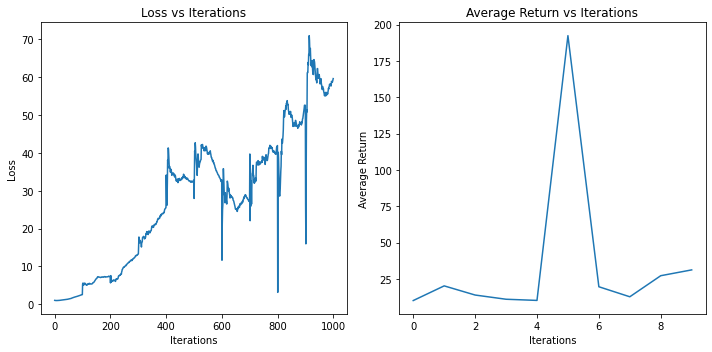

In [14]:
# Plot training loss and average return
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_results)
plt.title('Loss vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plot average return
plt.subplot(1, 2, 2)
plt.plot(average_return_results)
plt.title('Average Return vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Average Return')

plt.tight_layout()
plt.show()

## NOW THAT THE DQN AGENT HAS A BETTER POLICY TO INTERACT WITH THE ENVIRONMENT, LETS COLLECT SOME MORE EXPERIENCES AND STORE IT IN A NEW REPLAY BUFFER. THIS IS THE SET OF EXPERIENECS THAT THE BEHAVIORAL CLONING AGENT WILL LEARN FROM.

In [26]:
# Create a replay buffer to store trajectories
training_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length)
max_interactions = 1000
num_interactions = 0
while num_interactions < max_interactions:
    time_step = tf_env.reset()
    episode_step = 0
    while not time_step.is_last():
        action_step = agent.collect_policy.action(time_step)  # Use agent's collect_policy
        next_time_step = tf_env.step(action_step.action)
        traj = trajectory.from_transition(time_step, action_step, next_time_step)

        replay_buffer.add_batch(traj)

        time_step = next_time_step
        episode_step += 1
        num_interactions += 1

        if episode_step >= tf_env.pyenv.envs[0].env.spec.max_episode_steps:
            break

# Print the number of interactions and replay buffer size
print(f'Number of interactions: {num_interactions}')
print(f'Replay buffer size: {replay_buffer.num_frames().numpy()}')

Number of interactions: 1001
Replay buffer size: 32179


## INITIALIZE BEHAVIORAL CLONING AGENT

In [30]:
observation_spec = tf_env.observation_spec()
action_spec = tf_env.action_spec()

In [31]:
# Initialize the Actor Distribution Network
actor_net = actor_distribution_network.ActorDistributionNetwork(
    observation_spec,
    action_spec,
    fc_layer_params=(100,))

In [32]:
# Initialize the Behavioral Cloning Agent
train_step_counter = tf.Variable(0)
agent_b = BehavioralCloningAgent(
    time_step_spec=ts.time_step_spec(observation_spec),
    action_spec=action_spec,
    cloning_network=actor_net,
    optimizer=optimizer,
    train_step_counter=train_step_counter)

In [33]:
# Convert the replay buffer to a TensorFlow dataset
experience_dataset = training_replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=64,
    num_steps=1).prefetch(3)

In [34]:
experience_dataset_iterator = iter(experience_dataset)

In [35]:
# Make the Behavioral Cloning Agent's train function a TensorFlow graph function
agent_b.train = common.function(agent_b.train)

In [39]:
# Create a replay buffer to store trajectories
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length)

# Collect experiences from the DQN agent and store them in the replay buffer
max_interactions = 1000
num_interactions = 0
while num_interactions < max_interactions:
    time_step = tf_env.reset()
    episode_step = 0
    while not time_step.is_last():
        action_step = agent.collect_policy.action(time_step)  # Use agent's collect_policy
        next_time_step = tf_env.step(action_step.action)
        traj = trajectory.from_transition(time_step, action_step, next_time_step)

        replay_buffer.add_batch(traj)

        time_step = next_time_step
        episode_step += 1
        num_interactions += 1

        if episode_step >= tf_env.pyenv.envs[0].env.spec.max_episode_steps:
            break

# Print the number of interactions and replay buffer size
print(f'Number of interactions: {num_interactions}')
print(f'Replay buffer size: {replay_buffer.num_frames().numpy()}')

# Initialize the Behavioral Cloning Agent
train_step_counter = tf.Variable(0)
agent_b = BehavioralCloningAgent(
    time_step_spec=ts.time_step_spec(observation_spec),
    action_spec=action_spec,
    cloning_network=actor_net,
    optimizer=optimizer,
    train_step_counter=train_step_counter)

# Convert the replay buffer to a TensorFlow dataset
experience_dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=64,
    num_steps=1).prefetch(3)

experience_dataset_iterator = iter(experience_dataset)

# Run the training loop
num_iterations = 1000  # adjust this to your needs
# Create a list to store the loss values
train_loss_list = []
for i in range(num_iterations):
    # Sample a batch of experiences from the replay buffer
    trajectories, _ = next(experience_dataset_iterator)
    
    # Train the agent on the sampled experiences
    train_loss = agent_b.train(trajectories)
    
    # Append the current loss value to the list
    train_loss_list.append(train_loss.loss)
    
    # Print the current iteration number and the training loss every 100 iterations
    if i % 100 == 0:
        print('Iteration:', i, 'Training loss:', train_loss.loss.numpy())

Number of interactions: 1001
Replay buffer size: 1001
Iteration: 0 Training loss: 0.16680779
Iteration: 100 Training loss: 0.21818723
Iteration: 200 Training loss: 0.30998352
Iteration: 300 Training loss: 0.31089747
Iteration: 400 Training loss: 0.24115083
Iteration: 500 Training loss: 0.22674099
Iteration: 600 Training loss: 0.07393971
Iteration: 700 Training loss: 0.23142342
Iteration: 800 Training loss: 0.3334771
Iteration: 900 Training loss: 0.21211949


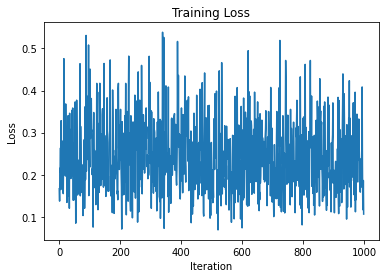

In [40]:
# Plot the training loss
plt.plot(train_loss_list)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## LET'S FIND OUT IF OUT BEHAVIORAL CLONING AGENT INTERACTS WITH CARTPOLE BETTER AFTER TRAINING ON THE REPLAY BUFFER FULL OF EEXPERIENCES

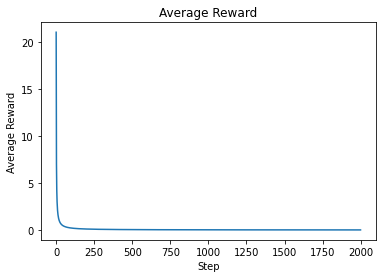

In [45]:
# Reset the environment
tf_env.reset()

# Initialize variables
total_reward = 0
rewards = []
average_rewards = []
num_eval_episodes = 2000
# Collect rewards by interacting with the environment
for step in range(num_eval_episodes):
    time_step = tf_env.current_time_step()
    while not time_step.is_last():
        # Get the agent's action based on the current time step
        action_step = agent_b.policy.action(time_step)
        
        # Apply the action to the environment
        next_time_step = tf_env.step(action_step.action)
        
        # Collect the reward
        reward = next_time_step.reward
        total_reward += reward
        
        # Update the time step
        time_step = next_time_step
    
    # Append the total reward for the episode
    rewards.append(total_reward)
    total_reward = 0
    
    # Calculate the average reward
    average_reward = sum(rewards) / len(rewards)
    average_rewards.append(average_reward)
    

# Plot the final average reward
plt.plot(average_rewards)
plt.title('Average Reward')
plt.xlabel('Step')
plt.ylabel('Average Reward')
plt.show()
